# News Sentiment Analysis – Natural Language Processing mit Transformern Baseline Modelle: Biontech

## Vorbereitung

In [1]:
#Laden der benötigten Bibliotheken
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
#Daten einlesen
data = pd.read_csv("Biontech.csv")

In [4]:
#Ersten Überblick über die Daten verschaffen
data.head()

,created_at,id,username,name,user_id,body,basic_sentiment
0,2021-12-31 23:32:20+00:00,422493745,Witstock,Colin Robinson,3315545,$MRNA $bntx RIP Betty…$spy $qqq $pfe,0.0
1,2021-12-31 23:26:39+00:00,422492859,15HY,ARN,5380284,$BNTX $PFE https://ig.ft.com/coronavirus-vacci...,0.0
2,2021-12-31 23:00:54+00:00,422488662,academyofstocks,Academy of Stocks,546853,Oversold stocks to buy in 2022 using DCF \n\n$...,NaN
3,2021-12-31 21:48:45+00:00,422473776,BiotechMike141,Michael Stewart,5453342,$BNTX Happy new year longs!!,0.0
4,2021-12-31 21:38:43+00:00,422471365,Witstock,Colin Robinson,3315545,@Poundsand07 another ancient aliens quack you ...,0.0


## Pre-Processing

In [6]:
#html tags und urls entfernen
from bs4 import BeautifulSoup
data["tweets_preproc"]=data["body"].apply(lambda x: BeautifulSoup(x).get_text())
import re
data["tweets_preproc"]=data["tweets_preproc"].apply(lambda x: re.sub(r"http\S+", "", x))

In [8]:
#Sonderzeichen etc. entfernen
data["tweets_preproc"]=data["tweets_preproc"].apply(lambda x: " ".join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))

In [9]:
#Überschüssige Leerzeichen entfernen
data["tweets_preproc"]=data["tweets_preproc"].apply(lambda x: re.sub(' +', ' ', x))

Weitere pre-processing Schritte (Lemmatization, Entfernen von Stopwords,...) wurden getestet, lieferten aber keine deutlichen Verbesserungen in der Modellgüte.

In [12]:
#Datumsvariable erstellen - um ggf. spaeter Ergebnisse zu plotten
data["created_at"] = pd.to_datetime(data.created_at, format='%Y-%m-%d %H:%M:%S')
data['date'] = data['created_at'].dt.strftime('%m/%d/%Y')

In [13]:
#Prüfen, ob alles geklappt hat
data.head()

,created_at,id,username,name,user_id,body,basic_sentiment,tweets_preproc,date
0,2021-12-31 23:32:20+00:00,422493745,Witstock,Colin Robinson,3315545,$MRNA $bntx RIP Betty…$spy $qqq $pfe,0.0,MRNA bntx RIP Betty spy qqq pfe,12/31/2021
1,2021-12-31 23:26:39+00:00,422492859,15HY,ARN,5380284,$BNTX $PFE https://ig.ft.com/coronavirus-vacci...,0.0,BNTX PFE,12/31/2021
2,2021-12-31 23:00:54+00:00,422488662,academyofstocks,Academy of Stocks,546853,Oversold stocks to buy in 2022 using DCF \n\n$...,NaN,Oversold stocks to buy in using DCF BABA BNTX ...,12/31/2021
3,2021-12-31 21:48:45+00:00,422473776,BiotechMike141,Michael Stewart,5453342,$BNTX Happy new year longs!!,0.0,BNTX Happy new year longs,12/31/2021
4,2021-12-31 21:38:43+00:00,422471365,Witstock,Colin Robinson,3315545,@Poundsand07 another ancient aliens quack you ...,0.0,Poundsand another ancient aliens quack you gu...,12/31/2021


In [14]:
#Datensatz nur mit gelabelten Tweets
data_labeled = data.dropna(subset = ["basic_sentiment"])
data_labeled = data_labeled.reset_index(drop=True)

## Sentiment Analysis

### 1 - VADER

In [16]:
#nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
#model
data_labeled["v_scores"] = data_labeled["tweets_preproc"].apply(lambda body: sid.polarity_scores(body))

In [17]:
#eigene Spalte für scores erstellen
data_labeled['compound']  = data_labeled['v_scores'].apply(lambda score_dict: score_dict['compound'])

In [18]:
#Predictions
data_labeled['v_sentiment'] = (
    np.where(
        data_labeled['compound'] > 0.05,0,
        np.where(data_labeled['compound'] < -0.05, 1, -99)))

Modellauswertung mittels Gütemaßen oder Confusion Matrix ist für VADER nicht sinnvoll, da VADER drei Klassen (positiv/neutral/negativ) hat, die Tweets im Datensatz aber nur zwei Klassen (positiv/negativ). Eine grafische Betrachtung folgt weiter unten.

### 2 - TF - IDF

In [21]:
#train / test split mit gleichen Anteilen der Klassen in Trainings- und Testdaten
from sklearn.model_selection import train_test_split
baseline_train,baseline_test = train_test_split(data_labeled,
                                                  stratify = data_labeled["basic_sentiment"],
                                                  test_size=0.1, random_state=42)
print("Training Set: ",baseline_train.shape, "Test Set: ",baseline_test.shape)

Training Set:  (3582, 12) Test Set:  (398, 12)


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), norm="l2")
vectorizer.fit(baseline_train["tweets_preproc"])
tf_x_train = vectorizer.transform(baseline_train["tweets_preproc"])
tf_x_test = vectorizer.transform(baseline_test["tweets_preproc"])

In [26]:
#SVM classifier
from sklearn import svm
svm = svm.SVC(class_weight={1:96.3, 0:3.7})

In [31]:
#Grid Search
from sklearn.model_selection import GridSearchCV
param_grid = [
  {'C': np.logspace(-3, 2, 6), 'kernel': ['linear']},
  {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-3, 2, 6), 'kernel': ['rbf']},
 ]

grid_search = GridSearchCV(svm, param_grid, n_jobs = -1, verbose = 2)
grid_search.fit(tf_x_train, baseline_train["basic_sentiment"])

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(estimator=SVC(class_weight={0: 3.7, 1: 96.3}), n_jobs=-1,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'kernel': ['linear']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'kernel': ['rbf']}],
             verbose=2)

In [32]:
print(grid_search.best_params_)

{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}


In [33]:
#Bestes Modell auf Testdaten anwenden und fitted values speichern
model_svm = grid_search.best_estimator_
y_fit_svm = model_svm.predict(tf_x_test)
baseline_test["sentiment_svm"] = y_fit_svm

In [ ]:
#Ergebnisse / Modellgüte
svm_results=classification_report(baseline_test["basic_sentiment"], y_fit_svm,output_dict=True)

In [35]:
cm_svm = confusion_matrix(baseline_test["basic_sentiment"], y_fit_svm)

In [37]:
svm_results

{'0.0': {'precision': 0.9623115577889447,
  'recall': 1.0,
  'f1-score': 0.9807938540332907,
  'support': 383},
 '1.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 15},
 'accuracy': 0.9623115577889447,
 'macro avg': {'precision': 0.48115577889447236,
  'recall': 0.5,
  'f1-score': 0.49039692701664533,
  'support': 398},
 'weighted avg': {'precision': 0.9260435342541855,
  'recall': 0.9623115577889447,
  'f1-score': 0.9438292615445988,
  'support': 398}}

[Text(0, 0.5, 'positive'), Text(0, 1.5, 'negative')]

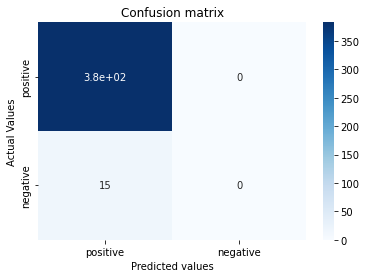

In [36]:
ax = sns.heatmap(cm_svm, annot=True, cmap = 'Blues')
ax.set_title('Confusion matrix')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual Values')
ax.xaxis.set_ticklabels(['positive','negative'])
ax.yaxis.set_ticklabels(['positive','negative'])

Modell funktioniert mit den Biontech Daten deutlich schlechter als mit den Apple Daten. Liegt an der zu geringen Anzahl negativer Tweets.

## Ergebnisse plotten

In [44]:
baseline_test["basic_sentiment"] = (np.where((baseline_test["basic_sentiment"] == 0) ,0,1))

In [45]:
baseline_test["sentiment_svm"] = (np.where((baseline_test["sentiment_svm"] == 0),0,1))

In [46]:
#Funktion, die Dummyvariablen erstellt und zum Dataframe hinzufügt
def dummies(dataframe, columns):
    dummy_df = pd.get_dummies(data = dataframe, columns = columns, dtype = np.float64)
    return dummy_df

In [47]:
dummy_vars = ['basic_sentiment','sentiment_svm','v_sentiment']
baseline_test = dummies(baseline_test, dummy_vars)

In [48]:
#Aggregieren
sentiment_scores_test = baseline_test.groupby("date").agg({'basic_sentiment_1': sum,
                                                           'basic_sentiment_0': sum,
                                                           'sentiment_svm_1': sum,
                                                           'sentiment_svm_0':sum,
                                                          'v_sentiment_0':sum,
                                                          'v_sentiment_1':sum,
                                                          'v_sentiment_-99':sum})                                          
                                                           

In [49]:
#Mean Sentiment Score berechnen
def sentiment_score(pos,neg):
    avg_score = (pos - neg) / (pos + neg)
    return avg_score

In [50]:
#Mean Sentiment Score berechnen (VADER)
def sentiment_vader(pos,neg,neutr):
    avg_score = (pos - neg) / (pos + neg + neutr)
    return avg_score

In [51]:
sentiment_scores_test["basic"] = sentiment_score(sentiment_scores_test["basic_sentiment_0"], sentiment_scores_test["basic_sentiment_1"])
sentiment_scores_test["predicted"] = sentiment_score(sentiment_scores_test["sentiment_svm_0"], sentiment_scores_test["sentiment_svm_1"])
sentiment_scores_test["vader"] = sentiment_vader(sentiment_scores_test["v_sentiment_0"], sentiment_scores_test["v_sentiment_1"], sentiment_scores_test["v_sentiment_-99"])

In [52]:
#Datumsvariable aus Index erstellen
sentiment_scores_test["date"] = sentiment_scores_test.index

In [53]:
sentiment_scores_test["date"] = pd.to_datetime(sentiment_scores_test.date, format='%m/%d/%Y')

In [66]:
#Plotten
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
%matplotlib inline

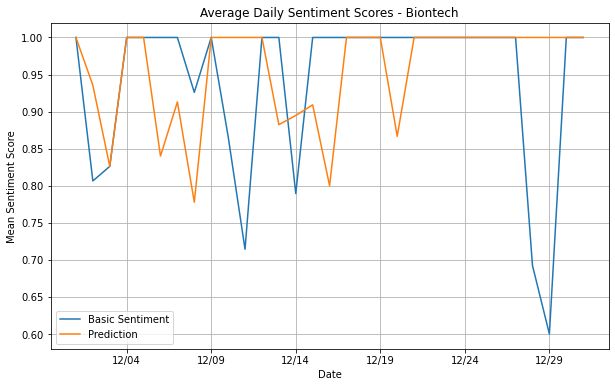

In [106]:
#TF-IDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sentiment_scores_test["date"],sentiment_scores_test.basic, label = 'Basic Sentiment')
ax.plot(sentiment_scores_test["date"], sentiment_scores_test["predicted"], label = 'Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Sentiment Score')
ax.set_title('Average Daily Sentiment Scores - Biontech')
ax.grid(True)
ax.legend(loc='lower left');

#format date axis
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
#change interval 
ax.xaxis.set_major_locator(ticker.AutoLocator())

Auch hier ist erkennbar, dass das Modell mit den Biontechdaten nur schlecht funktioniert.

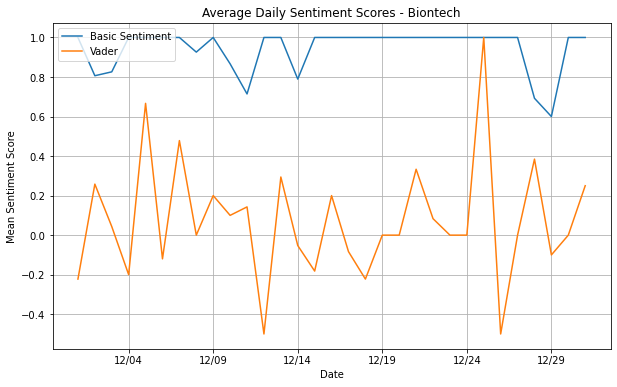

In [107]:
#VADER
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sentiment_scores_test["date"],sentiment_scores_test.basic, label = 'Basic Sentiment')
ax.plot(sentiment_scores_test["date"], sentiment_scores_test["vader"], label = 'Vader')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Sentiment Score')
ax.set_title('Average Daily Sentiment Scores - Biontech')
ax.grid(True)
ax.legend(loc='upper left');

#format date axis
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
#change interval 
ax.xaxis.set_major_locator(ticker.AutoLocator())

Auch VADER liefert keine verwendbaren Ergebnisse, da viele Tweets als neutral klassifiziert werden.